In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.envs.darkroom import DarkroomEnv
from decoding_utils import fit_and_evaluate_regression, fit_and_evaluate_circular_regression, fit_and_evaluate_classification

# Load Model

In [2]:
corr = 0.25
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "darkroom_simple")
eval_dset_path = os.path.join(os.path.dirname(eval_dset_path), 'train.pkl')

epoch=13-val_loss=0.911523.ckpt


In [3]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))
maze_dim = int(re.search(r'_dim(\d+)_corr', eval_dset_path).group(1))
node_encoding_corr = float(re.search(r'corr(\d*\.?\d*)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": state_dim,
    "action_dim": 5,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [4]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

# Load Dataset and Create Environment

In [5]:
n_eval_envs = 500

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [6]:
seq_length = 200

# Helper functions

In [7]:
def run_model(traj, model, seq_length=200, start_idx=0, zero_reward=False):
    hidden_states = []

    batch = {
        'context_states': convert_to_tensor([np.array(traj['context_states'])]),
        'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
        'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
        'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
        'query_states': convert_to_tensor([np.array(traj['query_state'])]),  # Ignored
        }
    batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
    if zero_reward:
        batch['context_rewards'] *= 0
    for k in batch.keys():
        if 'context' in k:
            batch[k] = batch[k][:,:seq_length]
        batch[k] = batch[k].to(model.device)
    model.save_activations = True
    with torch.no_grad():
        out = model(batch)
    _hidden_states = model.activations['hidden_states'] # Tuple over layers of (1, seq, dim)
    state_features = batch['context_states'][0][start_idx:].to('cpu').numpy()
    next_state_features = batch['context_next_states'][0][start_idx:].to('cpu').numpy()
    actions = batch['context_actions'][0].argmax(dim=1)[start_idx:].to('cpu').numpy()
    for i_layer in range(model.n_layer):
        hidden_states.append(_hidden_states[i_layer][0,start_idx:-1])
    return hidden_states, state_features, next_state_features, actions

In [8]:
def make_train_test_matrices():
    train_envs = np.arange(1, int(n_eval_envs*0.8))
    test_envs = np.arange(int(n_eval_envs*0.8), n_eval_envs)

    X_train = [[] for _ in range(model.n_layer)]
    X_test = [[] for _ in range(model.n_layer)]
    Ys_dict = {
        "dist_from_goal": {"Y_train": [], "Y_test": []},
        "euclidean_dist_from_goal": {"Y_train": [], "Y_test": []},
        "angle_from_goal": {"Y_train": [], "Y_test": []},
        "node_identity": {"Y_train": [], "Y_test": []},
        'is_goal': {"Y_train": [], "Y_test": []},
        'state_feature': {"Y_train": [], "Y_test": []},
        'next_state_feature': {"Y_train": [], "Y_test": []},
        "action": {"Y_train": [], "Y_test": []},
        "x": {"Y_train": [], "Y_test": []},
        "y": {"Y_train": [], "Y_test": []},
        "avg_x": {"Y_train": [], "Y_test": []},
        "avg_y": {"Y_train": [], "Y_test": []},
        "delta_x": {"Y_train": [], "Y_test": []},
        "delta_y": {"Y_train": [], "Y_test": []}
    }
    
    for i_eval in range(n_eval_envs):
        traj = eval_trajs[i_eval]
        first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
        if (first_reward.size == 0) or (first_reward[0] > seq_length):
            continue
        start_idx = first_reward[0].item()

        env_config = {
            'maze_dim': maze_dim,
            'horizon': 200,
            'state_dim': state_dim,
            'node_encoding_corr': node_encoding_corr,
            'initialization_seed': np.array(traj['initialization_seed']).item(),
            'goal': np.array(traj['goal'])
        }
        env = DarkroomEnv(**env_config)
        opt_action_map, dist_from_goal = env.make_opt_action_dict()

        hidden_states, state_features, next_state_features, actions = run_model(traj, model, seq_length, start_idx)
        goal_node = env.node_map_encoding_to_pos[tuple(env.goal.tolist())]
        seen_combos = set()
        for state_idx in reversed(range(len(state_features))):
            state_feature = state_features[state_idx]
            next_state_feature = next_state_features[state_idx]
            state_feature_tuple = tuple(state_feature.tolist())
            next_state_feature_tuple = tuple(next_state_feature.tolist())
            if next_state_feature_tuple == state_feature_tuple:
                continue
            chosen_feature = state_feature_tuple
            action = actions[state_idx]
            combo = tuple(state_feature.tolist() + next_state_feature.tolist())
            if combo in seen_combos:
                continue
            seen_combos.add(combo)
            d = dist_from_goal[chosen_feature]
            node_identity = env.node_map_encoding_to_pos[chosen_feature]
            avg_x = (env.node_map_encoding_to_pos[state_feature_tuple][0] + env.node_map_encoding_to_pos[next_state_feature_tuple][0])/2
            avg_y = (env.node_map_encoding_to_pos[state_feature_tuple][1] + env.node_map_encoding_to_pos[next_state_feature_tuple][1])/2

            Y_key = "Y_train" if i_eval in train_envs else "Y_test"
            Ys_dict["dist_from_goal"][Y_key].append(d)
            Ys_dict["angle_from_goal"][Y_key].append(
                np.arctan2(goal_node[1] - node_identity[1], goal_node[0] - node_identity[0])
                )
            Ys_dict['euclidean_dist_from_goal'][Y_key].append(
                np.linalg.norm(np.array(goal_node) - np.array(node_identity))
                )
            Ys_dict["node_identity"][Y_key].append(node_identity)
            Ys_dict["is_goal"][Y_key].append(chosen_feature == tuple(env.goal.tolist()))
            Ys_dict["state_feature"][Y_key].append(state_feature)
            Ys_dict["next_state_feature"][Y_key].append(next_state_feature)
            Ys_dict["action"][Y_key].append(action)
            Ys_dict["x"][Y_key].append(node_identity[0])
            Ys_dict["y"][Y_key].append(node_identity[1])
            Ys_dict["avg_x"][Y_key].append(avg_x)
            Ys_dict["avg_y"][Y_key].append(avg_y)
            Ys_dict["delta_x"][Y_key].append(goal_node[0] - node_identity[0])
            Ys_dict["delta_y"][Y_key].append(goal_node[1] - node_identity[1])
            
            for layer in range(len(hidden_states)):
                hidden_state = hidden_states[layer][state_idx].to('cpu').numpy()
                if i_eval in train_envs:
                    X_train[layer].append(hidden_state)
                else:
                    X_test[layer].append(hidden_state)
        torch.cuda.empty_cache()

    return X_train, X_test, Ys_dict

In [9]:
def plot_heatmaps(test_score, Ys_dict):
    n_layers = len(test_score)
    
    # Get x and y test data
    X_test = Ys_dict['x']['Y_test']
    Y_test = Ys_dict['y']['Y_test']
    
    # Create figure with subplots for each layer
    fig, axes = plt.subplots(1, n_layers, figsize=(5*n_layers, 5))
    if n_layers == 1:
        axes = [axes]
    score_grids = []
    
    for layer_idx, layer_scores in enumerate(test_score):
        # Assuming X_test and Y_test contain coordinates
        # First, create a grid to store average scores
        x_unique = np.unique(X_test)
        y_unique = np.unique(Y_test)
        
        # Initialize grid with NaN values
        score_grid = np.full((len(y_unique), len(x_unique)), np.nan)
        
        # Calculate average score for each x,y location
        for x_idx, x_val in enumerate(x_unique):
            for y_idx, y_val in enumerate(y_unique):
                # Find indices where X_test == x_val and Y_test == y_val
                mask = (X_test == x_val) & (Y_test == y_val)
                if np.any(mask):
                    # Calculate average score for this x,y location
                    score_grid[y_idx, x_idx] = np.mean(np.array(layer_scores)[mask])
        score_grids.append(score_grid)

    vmin = min(m.min() for m in score_grids)
    vmax = max(m.max() for m in score_grids)    
    for layer_idx, score_grid in enumerate(score_grids):       # Plot heatmap
        ax = axes[layer_idx]
        heatmap = sns.heatmap(score_grid, annot=True, fmt=".2f", cmap="viridis", 
                              xticklabels=x_unique, yticklabels=y_unique, ax=ax,
                              vmin=vmin, vmax=vmax)
        
        ax.set_title(f'Layer {layer_idx+1}')
        ax.set_xlabel('X coordinate')
        ax.set_ylabel('Y coordinate')
    
    plt.tight_layout()
    plt.show()

# Collect data and run decoding

In [10]:
X_train, X_test, Ys_dict = make_train_test_matrices()

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Layer 0:
Best alpha: 10000.000
Train R2: 0.081
Test R2: 0.060

Layer 1:
Best alpha: 166.810
Train R2: 0.609
Test R2: 0.584

Layer 2:
Best alpha: 166.810
Train R2: 0.873
Test R2: 0.858

Layer 0:
Best alpha: 10000.000
Train R2: 0.078
Test R2: 0.073

Layer 1:
Best alpha: 166.810
Train R2: 0.625
Test R2: 0.605

Layer 2:
Best alpha: 166.810
Train R2: 0.876
Test R2: 0.869



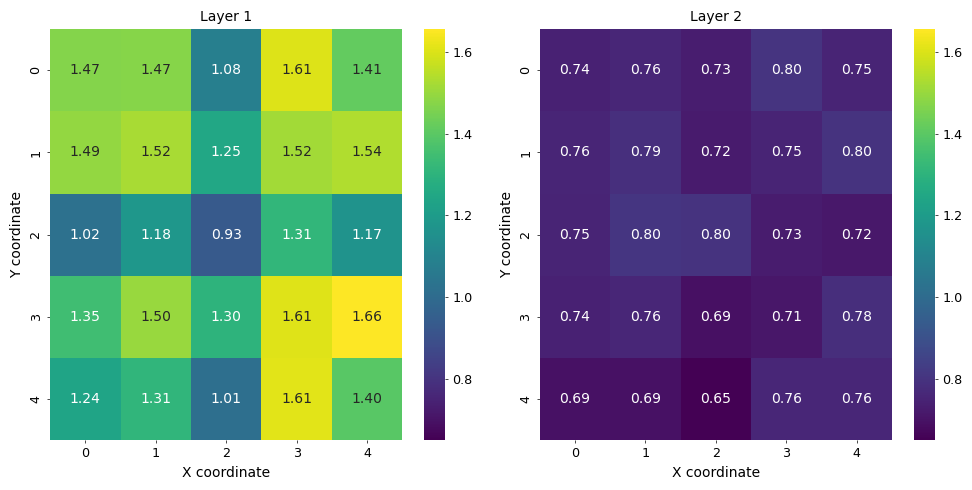

In [11]:
results = {
    'test_score_x': [],
    'test_score_y': [],
    'test_x': [],
    'test_pred_x': [],
    'test_y': [],
    'test_pred_y': [],
}
pipeline, test_score_x, test_x, test_pred_x = fit_and_evaluate_regression(
    X_train, 
    Ys_dict["x"]["Y_train"], 
    X_test, 
    Ys_dict["x"]["Y_test"],
    make_plot=False,
)

pipeline, test_score_y, test_y, test_pred_y = fit_and_evaluate_regression(
    X_train, 
    Ys_dict["y"]["Y_train"], 
    X_test, 
    Ys_dict["y"]["Y_test"],
    make_plot=False,
)

plot_heatmaps([np.array(test_score_x[i]) + np.array(test_score_y[i]) for i in range(1, len(test_score_x))], Ys_dict)

results['test_score_x'] = test_score_x
results['test_score_y'] = test_score_y
results['test_x'] = test_x
results['test_pred_x'] = test_pred_x
results['test_y'] = test_y
results['test_pred_y'] = test_pred_y
with open('pickles/09_buffer_token_decoding_x_y.pkl', 'wb') as f:
    pickle.dump(results, f)

Layer 0:
Best alpha: 1.000
Train mean circular error: 1.292 radians (74.0°)
Test mean circular error: 1.390 radians (79.7°)



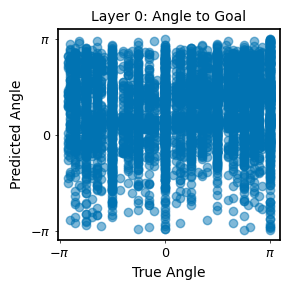

Layer 1:
Best alpha: 7.743
Train mean circular error: 0.771 radians (44.2°)
Test mean circular error: 0.904 radians (51.8°)



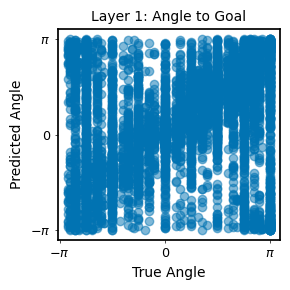

Layer 2:
Best alpha: 166.810
Train mean circular error: 0.244 radians (14.0°)
Test mean circular error: 0.288 radians (16.5°)



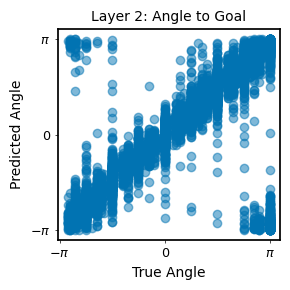

In [12]:
pipeline, test_score, test_y, test_pred = fit_and_evaluate_circular_regression(
    X_train, 
    Ys_dict["angle_from_goal"]["Y_train"], 
    X_test, 
    Ys_dict["angle_from_goal"]["Y_test"],
)
results = {
    'test_score': test_score,
    'test_y': test_y,
    'test_pred': test_pred,
}
with open('pickles/09_buffer_token_decoding_goal_angle.pkl', 'wb') as f:
    pickle.dump(results, f)